In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/MYK/Desktop/IRES/scripts')

import matplotlib.pyplot as plt
import numpy as np
import utils as u
import pandas as pd
import scipy.stats as ss
import seaborn as sns

# NOTE: profiles should not be plotted with same indices as Dstatistic array, as D statistic array does not have that of the null value.

## Subtract abs val of min of each profile to prevent neg val on CDF

In [2]:
#calibrated and normalized profile created from notebook J0332_gaussian_fitting
prof = np.loadtxt('./data/J0332_profs.txt')

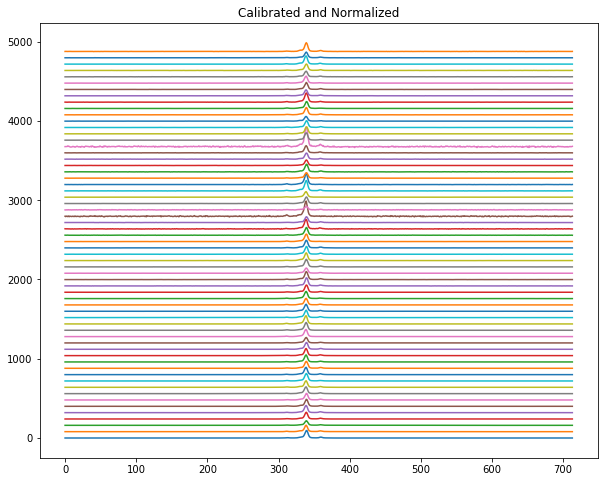

In [3]:
plt.figure(figsize=(10,8))
for i,val in enumerate(prof):
    plt.plot(val + i*80)
plt.title('Calibrated and Normalized')
plt.show()

In [4]:
nprofs = len(prof)
offset = np.max(np.abs([i.min() for i in prof]))

for i, val in enumerate(prof):
    cal = val + offset #to prevent negative values in cdf
    prof[i] = cal / np.trapz(cal) #renormalize after adding offset

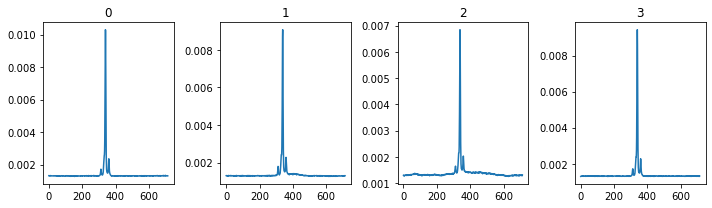

In [5]:
#pick index = 0 as "template"
u.gridplot(prof[:4],4,hist=False, figsize=(10,3))

# 1000 sim on index 0 profile, perform KS-test against ind0 and plot D-statistic

In [6]:
#here null is cdf of profile index 0
null = np.cumsum(prof[0]) 
#null = null / np.sum(null)#normalize cdf
np.savetxt('./R_analysis/null.txt',null)

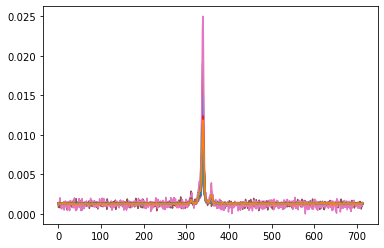

In [7]:
for i in prof:
    plt.plot(i)
plt.show()

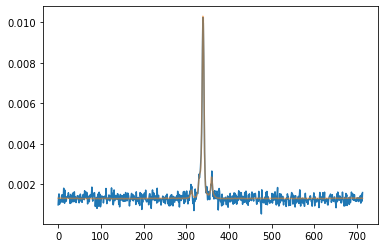

In [8]:
sigma=.0002
nbins=714
noise_prof = prof[0] + np.random.randn(nbins)*sigma #add noise
plt.plot(noise_prof)
plt.plot(prof[0], alpha=.5)



In [9]:
#add noise to 1000 copies of null profile (index 0), take cdf and store as 2d array 1000 x nbins
nsims = 1000
nbins = prof.shape[1]
sigma = .0003
sim_cdf = np.zeros((nsims,nbins))

for i in range(nsims):
    noise_prof = prof[0] + np.random.randn(nbins)*sigma #add noise
    cumsum = np.cumsum(noise_prof) #compute cdf
    sim_cdf[i] = cumsum# / np.sum(cumsum) #normalize, add to sim_cdf 
    

In [10]:
#save simulated cdf 2D array
np.savetxt('./R_analysis/sim_cdf.txt',sim_cdf)

In [11]:
#load D-values from ks test between reference template and simulated templates
D_sim = np.loadtxt('../R_analysis/sim_Dvalues.txt')

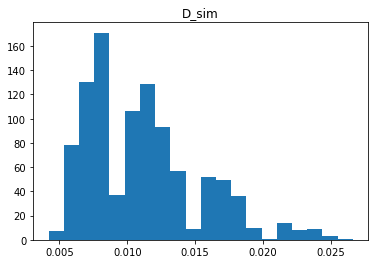

In [12]:
plt.hist(D_sim,bins=20)
plt.title("D_sim")
plt.show()

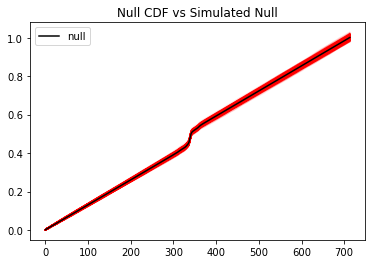

In [13]:
for i in range(nsims):
    plt.plot(sim_cdf[i], alpha=.1, color='r')
plt.plot(null, 'k', label='null')
plt.legend(loc=2)
plt.title("Null CDF vs Simulated Null")
plt.show()

# Create CDF of other profiles (ind!=0), KS-test against ind0 prof, plot D statistic

In [14]:
#create 2D array to store cdf of other profiles
cdf = np.zeros((len(prof)-1,nbins))

for i in range(len(cdf)):
    cumsum = np.cumsum(prof[i+1]) #+1 to skip reference profile at index 0
    cdf[i] = cumsum #/ np.sum(cumsum) #normalize

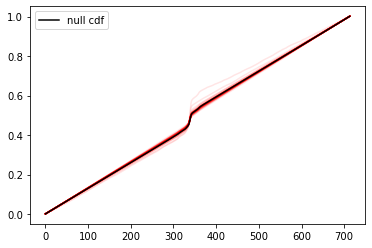

In [15]:
for i in range(len(cdf)):
    plt.plot(cdf[i],'r', alpha=.1)
plt.plot(null,'k', label='null cdf')
plt.legend()
plt.show()

In [16]:
#save cdfs
np.savetxt('./R_analysis/cdf.txt',cdf)

## Note getting warnings of ties present in CDF (ie repeated values, which is not possible for continuous distr. But we are using ks_test which has ability to work on 2 discrete distr so okay?

In [17]:
#import D statistic from ks test between null cdf and other cdfs
D_real = np.loadtxt('./R_analysis/real_Dvalues.txt')

/Users/MYK/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/MYK/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/MYK/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/MYK/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/MYK/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbo

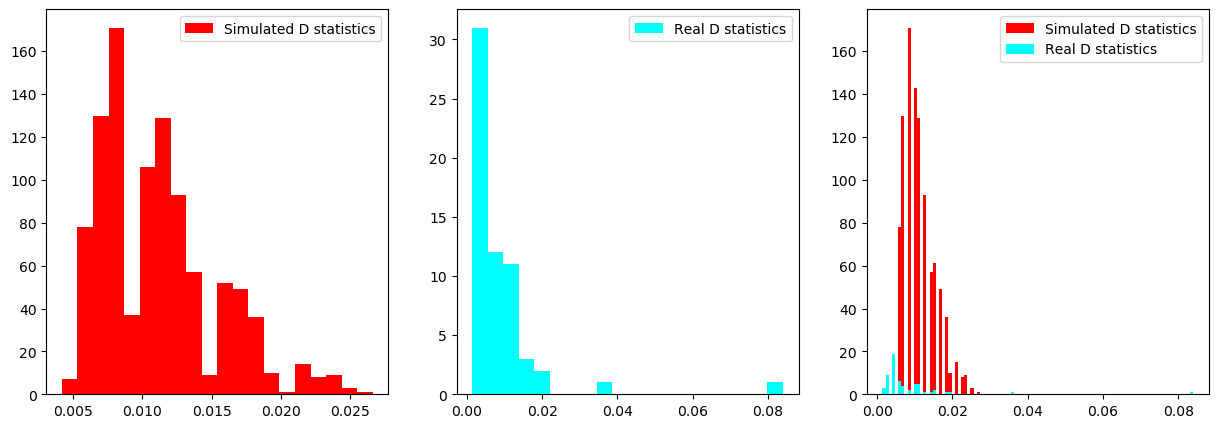

In [18]:
sns.reset_orig()
min_bin = np.min([np.min(D_sim), np.min(D_real)])
max_bin = np.max([np.max(D_sim), np.max(D_real)])
bins = np.linspace(min_bin, max_bin, 100)

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

ax1.hist(D_sim, bins=20, color='r', label='Simulated D statistics')
ax1.legend()

ax2.hist(D_real, bins=20, color='cyan', label='Real D statistics')
ax2.legend()

ax3.hist(D_sim, bins=bins, color='r', label='Simulated D statistics')
ax3.hist(D_real, bins=bins, color='cyan', label='Real D statistics')
ax3.legend()
plt.show()

# Plot D-statistic as function of epoch

In [20]:
D_sim.max(), np.percentile(D_sim, q=97.5), np.percentile(D_sim, q=2.5)

(0.0266106442577031, 0.0210084033613446, 0.00560224089635858)

In [21]:
#Set critical value of D statistic as 95th percentile
D_crit = np.percentile(D_sim, q=90)

#import MJD
mjd_orig = np.loadtxt('J0332_MJD.txt')
mjd_arr = mjd_orig[1:] #remove first element, because that is MJD of refernce profile

In [22]:
#create pandas object
data = np.vstack((mjd_arr, D_real))
df = pd.DataFrame(data, index=['MJD', 'D_statistic']).T

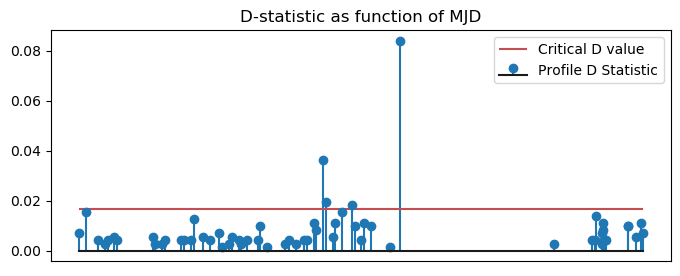

In [23]:
#plot D-statistic as function of MJD
sns.reset_orig()
fig = plt.figure(figsize=(8,3))
plt.stem(df['MJD'], df['D_statistic'], label='Profile D Statistic', basefmt='k', use_line_collection=True)
plt.hlines(y=D_crit, xmin=mjd_arr[0], xmax=mjd_arr[-1], color='r', label='Critical D value')
plt.legend()
plt.title('D-statistic as function of MJD')
plt.xticks([])
plt.savefig('./plots/Dstat_stem.jpeg')
plt.show()

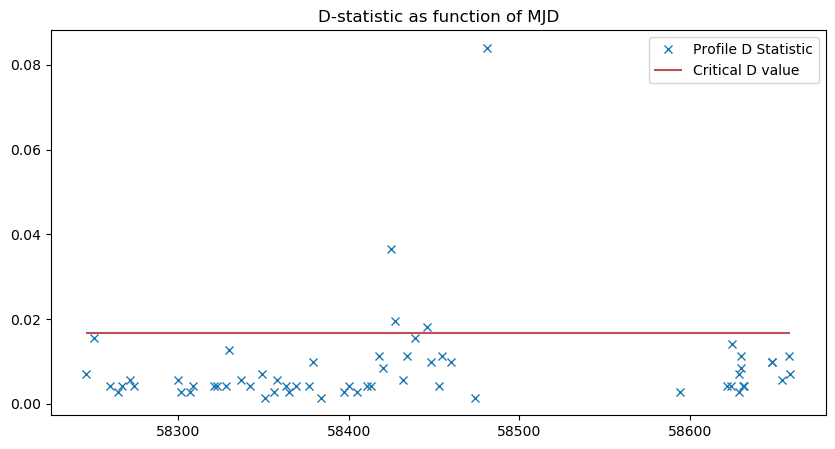

In [24]:
#plot D-statistic as function of MJD
fig = plt.figure(figsize=(10,5))
plt.plot(df['MJD'], df['D_statistic'], 'x', label='Profile D Statistic')
plt.hlines(y=D_crit, xmin=mjd_arr[0], xmax=mjd_arr[-1], color='r', label='Critical D value')
plt.legend()
plt.title('D-statistic as function of MJD')
plt.savefig('./plots/Dstat_scatter.jpg')
plt.show()

In [25]:
mask = df['D_statistic'] > D_crit
mode_change = df['MJD'][mask]
mode_change.head()

34    58425.0
35    58427.0
39    58446.0
45    58481.0
Name: MJD, dtype: float64

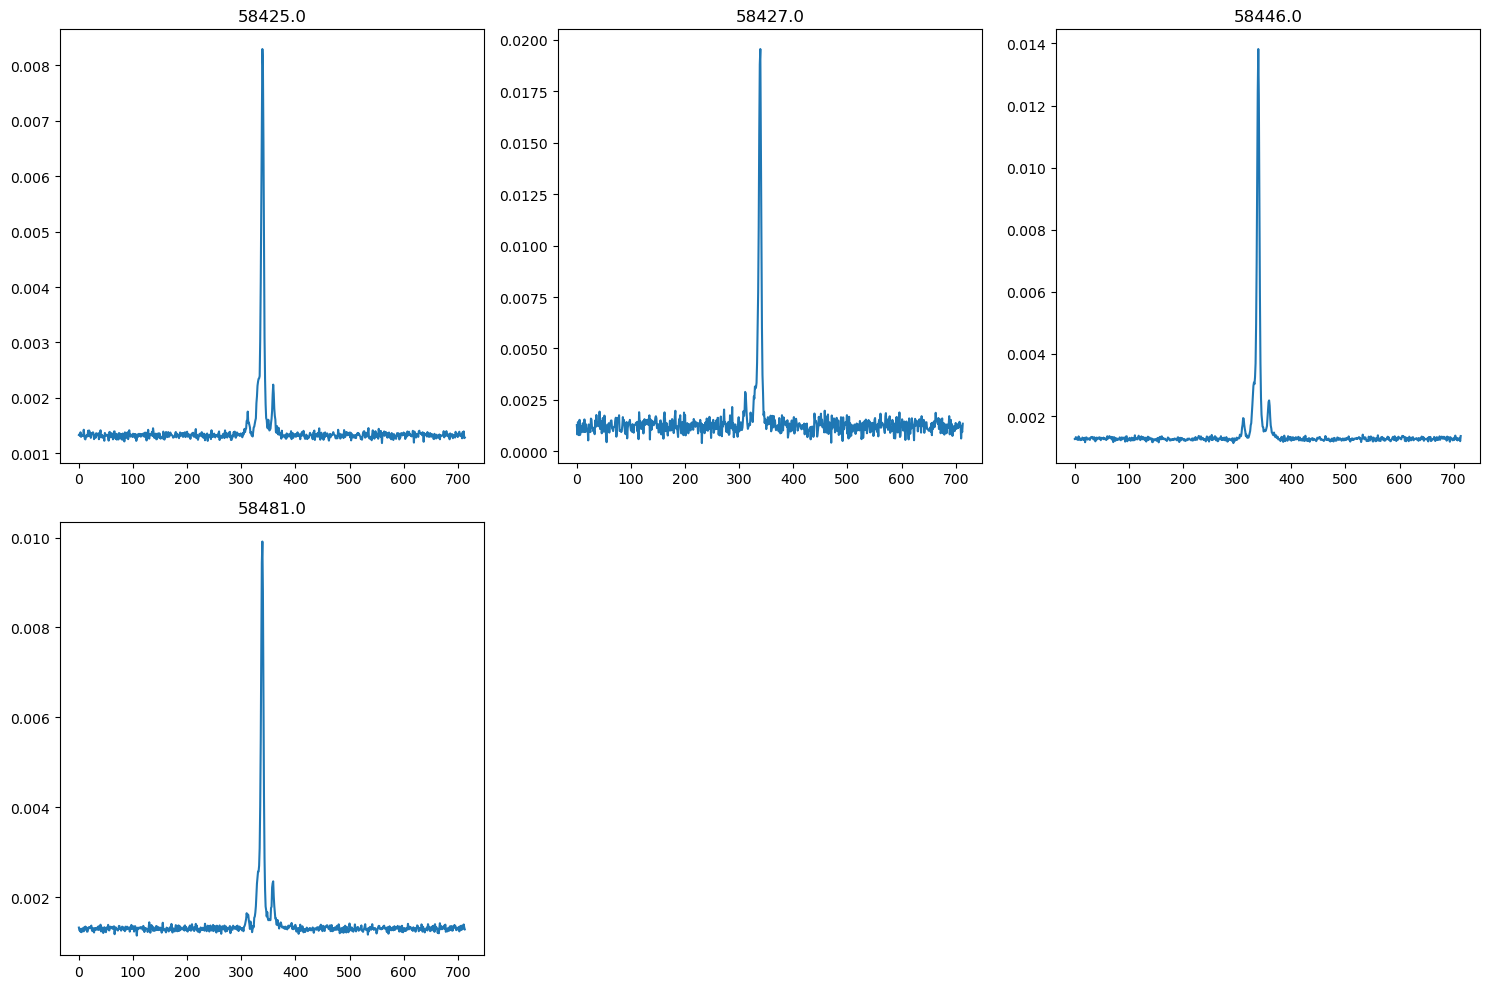

In [26]:
fig = plt.figure(figsize=(15,10))
for i, pd_ind in enumerate(mode_change.index):
    ax = fig.add_subplot(len(mode_change)//3 + 1, 3, i+1)
    ax.plot(prof[pd_ind]) #no need to add 1 for null prof because pd index starts from 1
    ax.set_title(mode_change.loc[pd_ind])
plt.tight_layout()
plt.show()

In [27]:
df['mode'] = [1 if D > D_crit else 0 for D in df.D_statistic]
df.head()

,MJD,D_statistic,mode
0,58246.0,0.007003,0
1,58251.0,0.015406,0
2,58260.0,0.004202,0
3,58265.0,0.002801,0
4,58267.0,0.004202,0


In [28]:
def snr(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    
    return np.where(sd == 0, 0, m/sd)

In [29]:
snr_arr = np.zeros(len(prof)-1)#exclude first reference profile
for i in range(len(prof)-1):
    snr_arr[i] = snr(prof[i+1])

df['crude_snr'] = snr_arr

In [30]:
df.head()

,MJD,D_statistic,mode,crude_snr
0,58246.0,0.007003,0,2.403823
1,58251.0,0.015406,0,3.358646
2,58260.0,0.004202,0,2.319976
3,58265.0,0.002801,0,2.117018
4,58267.0,0.004202,0,2.212321


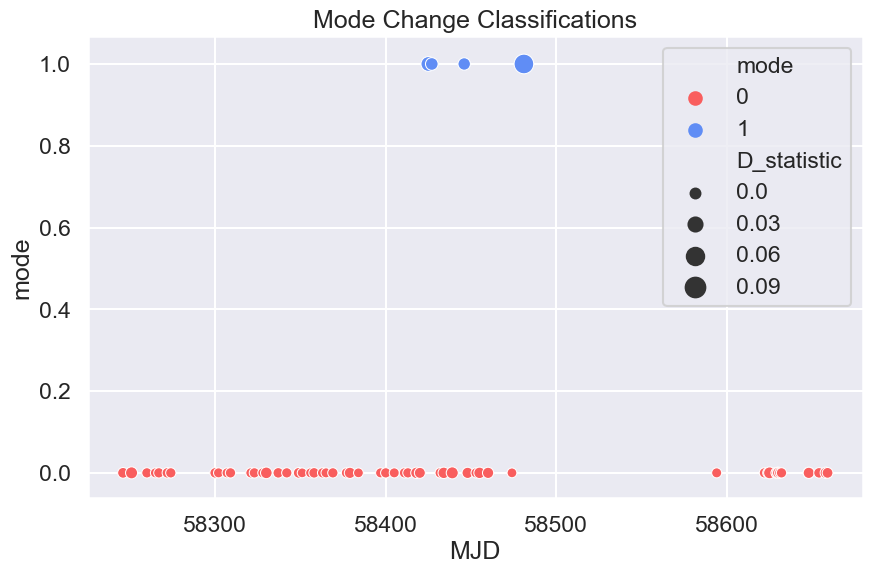

In [32]:
sns.set(context='talk', style='darkgrid')

fig = plt.figure(figsize=(10,6))
#cmap = sns.color_palette(palette='Set3', n_colors=2)
cmap = sns.color_palette(['#F95E5E', '#608DF5'])

ax = sns.scatterplot(x='MJD', y='mode', data=df, hue='mode', size='D_statistic', sizes=(50,200), \
                     palette=cmap)
ax.set_title('Mode Change Classifications')


#ax = sns.scatterplot(x='MJD', y='mode', data=df, hue='mode', size='crude_snr', sizes=(50,200), \
#                     palette=cmap)
#ax.set_title('Average Crude SNR %f' % snr(np.average(prof,axis=0)))

plt.savefig('./plots/mode_binary.jpeg')

## Known that normal mode (82.45%), abnormal mode (17.55%)
5.1 in
https://www2.physik.uni-bielefeld.de/fileadmin/user_upload/radio_astronomy/Publications/Bachelorthesis_MaxKreie.pdf

In [31]:
#nprofs-1 because we don't count null profile (ind=0)
len(df[df['mode'] == 0]) / (nprofs-1), len(df[df['mode'] == 1]) / (nprofs-1)

(0.9344262295081968, 0.06557377049180328)

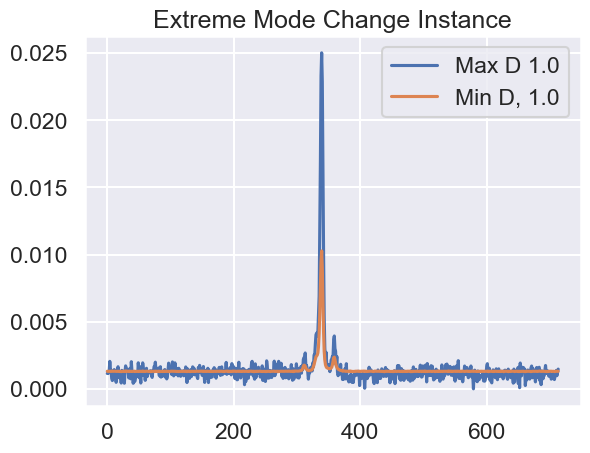

In [34]:
# visually compare profiles of those with min and max D statistic
plt.plot(prof[D_real.argmax() + 1],
         label='Max D {}'.format(round(np.trapz(prof[D_real.argmax() + 1]),3)))# +1 here because we don't want null profile!
plt.plot(prof[D_real.argmin() + 1], \
         label='Min D, {}'.format(round(np.trapz(prof[D_real.argmax() + 1]), 3)))
#plt.xlim(300, 400)
plt.legend()
plt.title('Extreme Mode Change Instance')
plt.savefig('./plots/mode_profile.jpg')
plt.show()

### Save mode change MJDs to use in test_comparison, remember to include the null profile as mode=0
Call mode=0 abnormal because it is less frequent

In [33]:
abn_mjd = df[df['mode'] == 1]['MJD'].tolist()
#insert null profile MJD at index 0, notice using mjd_orig not mjd_arr, which has null mjd removed
abn_mjd.insert(0, mjd_orig[0]) 

nor_mjd = df[df['mode'] == 0]['MJD'].tolist()

In [34]:
abn_mjd

[58244.0, 58425.0, 58427.0, 58446.0, 58481.0]

In [35]:
#save mjds
np.savetxt('./classified_mjd/J0332_norm_mjd_ks.txt', nor_mjd)
np.savetxt('./classified_mjd/J0332_abnorm_mjd_ks.txt', abn_mjd)